In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np

In [3]:
types = {'StateHoliday': np.dtype(str)}
train = pd.read_csv("/content/gdrive/MyDrive/futureSales/assets/train.csv", parse_dates=[2], nrows=66901, dtype=types)
store = pd.read_csv("/content/gdrive/MyDrive/futureSales/assets/store.csv")


In [4]:
not_open = train[(train['Open'] == 0) & (train['Sales'] != 0)]
print("No closed store with sales: " + str(not_open.size == 0))


No closed store with sales: True


In [5]:
no_sales = train[(train['Open'] == 1) & (train['Sales'] <= 0)]
print("No open store with no sales: " + str(no_sales.size == 0))


No open store with no sales: True


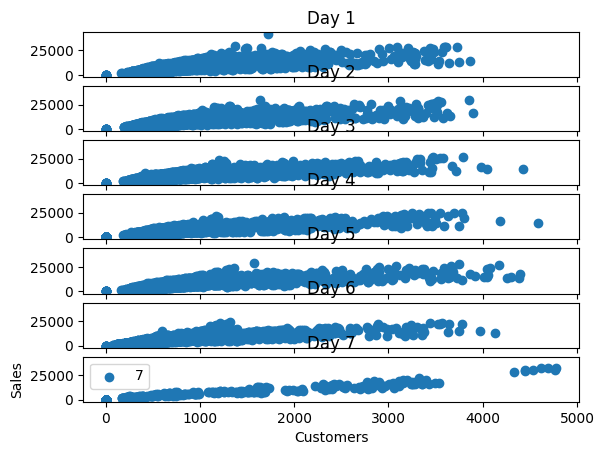

In [6]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(7, sharex=True, sharey=True)
for i in range(1, 8):
    mask = train[train['DayOfWeek'] == i]
    ax[i - 1].set_title("Day {0}".format(i))
    ax[i - 1].scatter(mask['Customers'], mask['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()


<ipython-input-7-3616624ade31>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))


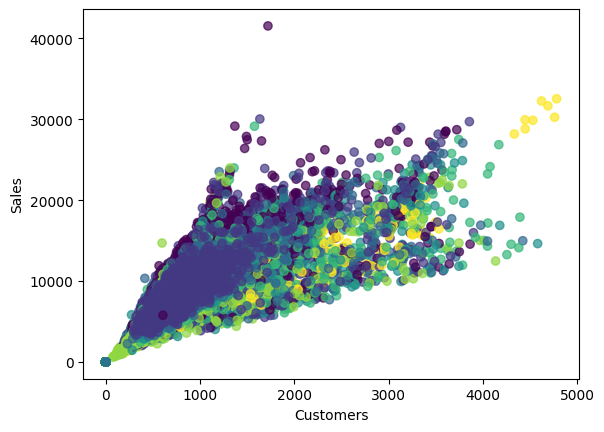

In [7]:
plt.scatter(train['Customers'], train['Sales'], c=train['DayOfWeek'], alpha=0.7, cmap=plt.cm.get_cmap('viridis'))

plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()


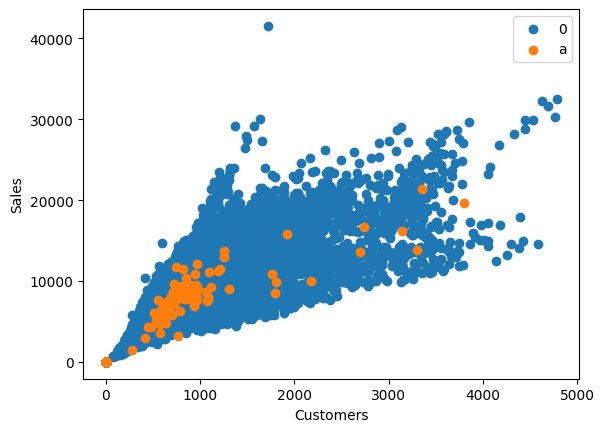

In [8]:
for i in ["0", "1" ,"a", "b", "c"]:
    data = train[train['StateHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()


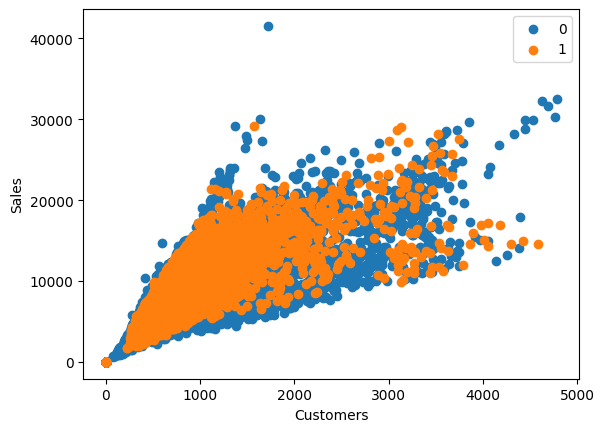

In [9]:

for i in [0, 1]:
    data = train[train['SchoolHoliday'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()


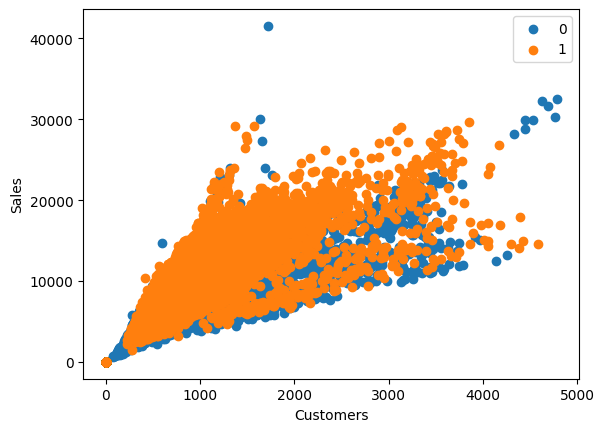

In [10]:
for i in [0, 1]:
    data = train[train['Promo'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['Customers'], data['Sales'], label=i)

plt.legend()
plt.xlabel('Customers')
plt.ylabel('Sales')
plt.show()


In [11]:
train['SalesPerCustomer'] = train['Sales'] / train['Customers']

avg_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].mean()
avg_store.rename(columns=lambda x: 'Avg' + x, inplace=True)
store = pd.merge(avg_store.reset_index(), store, on='Store')
store.head()


,Store,AvgSales,AvgCustomers,AvgSalesPerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,3791.426230,434.934426,8.670743,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,4332.266667,517.016667,8.459276,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,6030.983333,609.316667,9.785061,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,8530.850000,1101.933333,7.702043,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,3997.250000,453.250000,8.764831,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


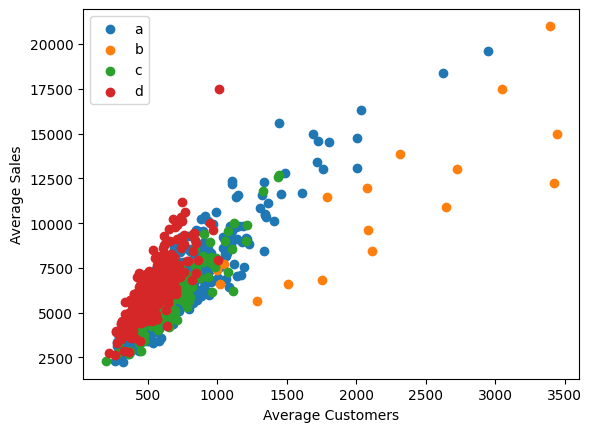

In [12]:
for i in ['a', 'b', 'c', 'd']:
    data = store[store['StoreType'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()


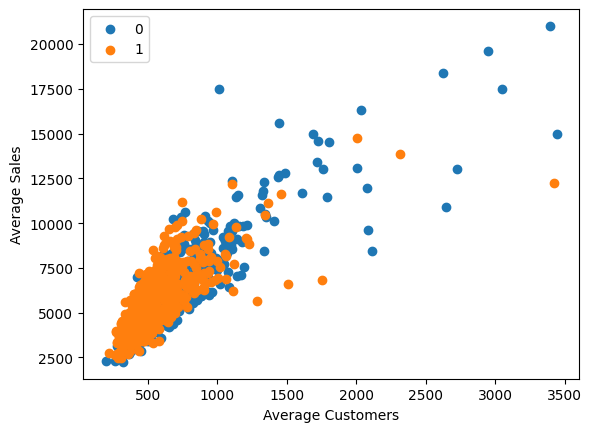

In [13]:
for i in [0, 1]:
    data = store[store['Promo2'] == i]
    if (len(data) == 0):
        continue
    plt.scatter(data['AvgCustomers'], data['AvgSales'], label=i)

plt.legend()
plt.xlabel('Average Customers')
plt.ylabel('Average Sales')
plt.show()


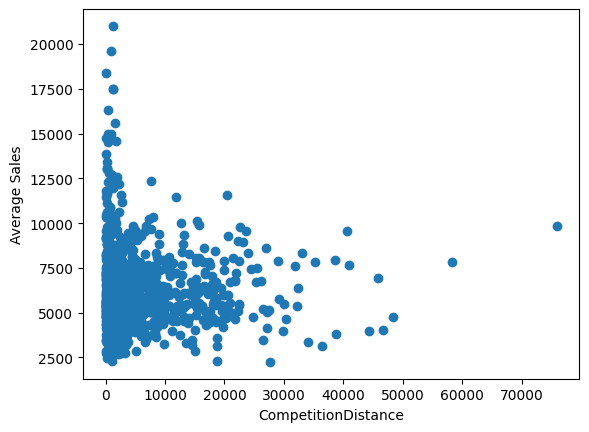

In [14]:
# fill NaN values
store["CompetitionDistance"].fillna(-1)
plt.scatter(store['CompetitionDistance'], store['AvgSales'])

plt.xlabel('CompetitionDistance')
plt.ylabel('Average Sales')
plt.show()


In [15]:
def build_features(train, store):
    # Convert string types into integers
    store['StoreType'] = store['StoreType'].astype('category').cat.codes
    store['Assortment'] = store['Assortment'].astype('category').cat.codes
    train["StateHoliday"] = train["StateHoliday"].astype('category').cat.codes

    merged = pd.merge(train, store, on='Store', how='left')

    # remove NaNs
    NaN_replace = 0
    merged.fillna(NaN_replace, inplace=True)

    merged['Year'] = merged.Date.dt.year
    merged['Month'] = merged.Date.dt.month
    merged['Day'] = merged.Date.dt.day
    merged['Week'] = merged.Date.dt.week

    # Number of months that competition has existed for
    merged['MonthsCompetitionOpen'] = \
        12 * (merged['Year'] - merged['CompetitionOpenSinceYear']) + \
        (merged['Month'] - merged['CompetitionOpenSinceMonth'])
    merged.loc[merged['CompetitionOpenSinceYear'] ==
               NaN_replace, 'MonthsCompetitionOpen'] = NaN_replace

    # Number of weeks that promotion has existed for
    merged['WeeksPromoOpen'] = \
        12 * (merged['Year'] - merged['Promo2SinceYear']) + \
        (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])
    merged.loc[merged['Promo2SinceYear'] ==
               NaN_replace, 'WeeksPromoOpen'] = NaN_replace

    toInt = [
        'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',
        'Promo2SinceWeek',
        'Promo2SinceYear',
        'MonthsCompetitionOpen',
        'WeeksPromoOpen'
    ]
    merged[toInt] = merged[toInt].astype(int)

    return merged

med_store = train.groupby('Store')[['Sales', 'Customers', 'SalesPerCustomer']].median()
med_store.rename(columns=lambda x: 'Med' + x, inplace=True)

store = pd.merge(med_store.reset_index(), store, on='Store')
features = build_features(train, store)
features.head()


<ipython-input-15-5dc1ec829914>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  merged['Week'] = merged.Date.dt.week
<ipython-input-15-5dc1ec829914>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,SalesPerCustomer,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,Week,MonthsCompetitionOpen,WeeksPromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,9.482883,...,0,0,0,0,2015,7,31,31,82,0
1,2,5,2015-07-31,6064,625,1,1,0,1,9.702400,...,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,31,31,92,78
2,3,5,2015-07-31,8314,821,1,1,0,1,10.126675,...,1,14,2011,"Jan,Apr,Jul,Oct",2015,7,31,31,103,65
3,4,5,2015-07-31,13995,1498,1,1,0,1,9.342457,...,0,0,0,0,2015,7,31,31,70,0
4,5,5,2015-07-31,4822,559,1,1,0,1,8.626118,...,0,0,0,0,2015,7,31,31,3,0


In [16]:
from sklearn.model_selection import train_test_split
X = [
    'Store',
    'Customers',
    'CompetitionDistance',

    'Promo',
    'Promo2',

#     'SchoolHoliday',
    'StateHoliday',
    'StoreType',
    'Assortment',

    'AvgSales',
    'AvgCustomers',
    'AvgSalesPerCustomer',

    'MedSales',
    'MedCustomers',
    'MedSalesPerCustomer',

    'DayOfWeek',
    'Week',
    'Day',
    'Month',
    'Year',

    'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear',
    'Promo2SinceWeek',
    'Promo2SinceYear',

#     'MonthsCompetitionOpen',
#     'WeeksPromoOpen'
]
X_train, X_test, y_train, y_test = train_test_split(
    features[X], features['Sales'], test_size=0.15, random_state=10)


In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Error calculating function according to kaggle
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

rmpse_scorer = make_scorer(rmspe, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, y_hat))

def plot_importance(model):
    k = list(zip(X, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)

    plt.barh(np.arange(len(X)), vals, align='center')
    plt.yticks(np.arange(len(X)), labels)


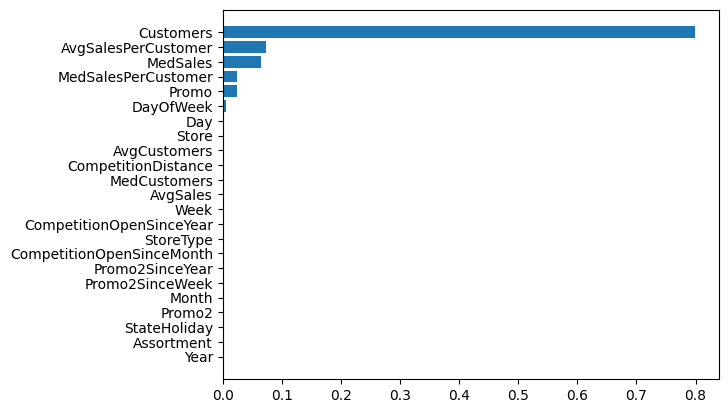

In [18]:
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
plot_importance(decision_tree)


In [19]:
y_hat = decision_tree.predict(X_test)
score(decision_tree, X_train, y_train, y_test, y_hat)


Mean -0.08478791472952311
Variance 2.1261127844813515e-06
RMSPE 0.08050917651543694


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.0s finished


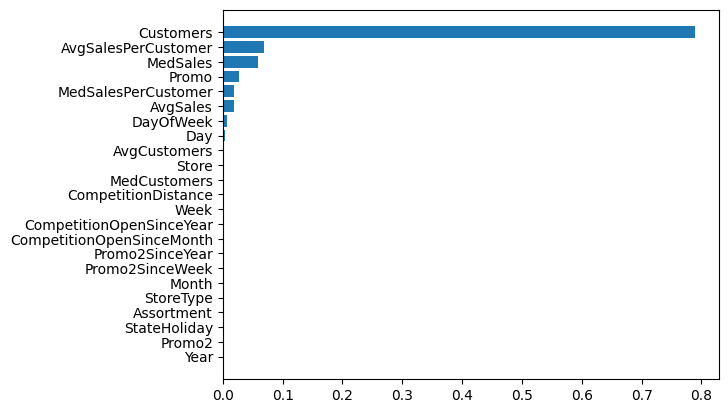

In [20]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
plot_importance(randomForest)


In [21]:
y_hat = randomForest.predict(X_test)
score(randomForest, X_train, y_train, y_test, y_hat)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  2

Mean -0.061687820417640774
Variance 8.156408640889288e-07
RMSPE 0.058616823651132285


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.7s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.1s finished


In [22]:
import xgboost as xgb

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[X], np.log1p(y_train),
                 eval_set = [(X_train[X], np.log1p(y_train)), (X_test[X], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )


[13:51:16] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-rmse:6.91883	validation_0-rmspe:inf	validation_1-rmse:6.94447	validation_1-rmspe:inf
[1]	validation_0-rmse:6.22819	validation_0-rmspe:inf	validation_1-rmse:6.25123	validation_1-rmspe:inf
[2]	validation_0-rmse:5.60675	validation_0-rmspe:inf	validation_1-rmse:5.62735	validation_1-rmspe:inf
[3]	validation_0-rmse:5.04755	validation_0-rmspe:inf	validation_1-rmse:5.06597	validation_1-rmspe:inf


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
<ipython-input-17-808dff85dd05>:6: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean(((y - y_hat) / y) ** 2))


[4]	validation_0-rmse:4.54437	validation_0-rmspe:inf	validation_1-rmse:4.56079	validation_1-rmspe:inf
[5]	validation_0-rmse:4.09180	validation_0-rmspe:inf	validation_1-rmse:4.10642	validation_1-rmspe:inf
[6]	validation_0-rmse:3.68450	validation_0-rmspe:inf	validation_1-rmse:3.69729	validation_1-rmspe:inf
[7]	validation_0-rmse:3.37468	validation_0-rmspe:inf	validation_1-rmse:3.38552	validation_1-rmspe:inf
[8]	validation_0-rmse:3.04232	validation_0-rmspe:inf	validation_1-rmse:3.05199	validation_1-rmspe:inf
[9]	validation_0-rmse:2.74044	validation_0-rmspe:inf	validation_1-rmse:2.74911	validation_1-rmspe:inf
[10]	validation_0-rmse:2.46897	validation_0-rmspe:inf	validation_1-rmse:2.47657	validation_1-rmspe:inf
[11]	validation_0-rmse:2.22473	validation_0-rmspe:inf	validation_1-rmse:2.23142	validation_1-rmspe:inf
[12]	validation_0-rmse:2.00513	validation_0-rmspe:inf	validation_1-rmse:2.01082	validation_1-rmspe:inf
[13]	validation_0-rmse:1.81024	validation_0-rmspe:inf	validation_1-rmse:1.81512

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

Note that this is not in percentage, thus not to scale of graphs above


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

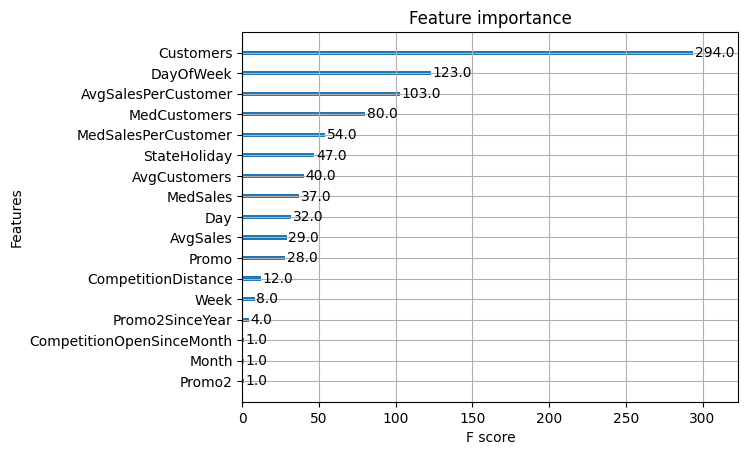

In [23]:
print("Note that this is not in percentage, thus not to scale of graphs above")
xgb.plot_importance(xgboost_tree)


In [24]:
def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Mean', score.mean())
    print('Variance', score.var())
    print('RMSPE', rmspe(y_test, np.expm1(y_hat)))

y_hat = xgboost_tree.predict(X_test[X])
score(xgboost_tree, X_train[X], np.log1p(y_train), y_test, y_hat)


[13:51:28] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[13:51:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[13:52:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[13:52:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[13:52:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

Mean -inf
Variance nan
RMSPE inf


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [25]:
test = pd.read_csv("/content/gdrive/MyDrive/futureSales/assets/test.csv", parse_dates=[2], dtype=types)
features = build_features(test, store)

y_hat = np.expm1(xgboost_tree.predict(features[X]))

df = pd.DataFrame({"Id": range(1, len(test) + 1), 'Sales': y_hat})
df.loc[test['Open'] == 0, 'Sales'] = 1
df.to_csv('sales.csv', index=False)


<ipython-input-15-5dc1ec829914>:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  merged['Week'] = merged.Date.dt.week
<ipython-input-15-5dc1ec829914>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  (merged['Date'].dt.weekofyear - merged['Promo2SinceWeek'])


In [26]:
df.head


<bound method NDFrame.head of           Id     Sales
0          1  2.664946
1          2  2.664946
2          3  2.867891
3          4  2.867891
4          5  2.664946
...      ...       ...
33445  33446  2.664946
33446  33447  2.664946
33447  33448  2.867891
33448  33449  2.867891
33449  33450  2.664946

[33450 rows x 2 columns]>